
# Project Title : Microsoft Stock Price Prediction



(Referenced: Tatsat’s book, chapter 5, Case Study :1,
https://bit.ly/3Fa4D2F)

In [ ]:
# Importing all the relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib 
import pywt
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from scipy.stats import spearmanr
import tqdm
from functools import partial
import detrendPrice 
import WhiteRealityCheckFor1 
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
import optuna

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA


# Regression Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor


# Classification Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Defining spearman's rank correlation function
def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    return rho

# Defining sharpe ratio function to evaluate performaces
def sharpe(y_true, y_pred):
    positions = np.where(y_pred.reshape(-1)> 0,1,-1 )
    dailyRet = pd.Series(positions).shift(1).fillna(0).values * y_true
    dailyRet = np.nan_to_num(dailyRet)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
    return ratio

# Defining phi_k function to evaluate performaces
def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    return phi_k_corr

def split_time_series(time_series, train_size):
    l = len(time_series)
    split_point = int(l * train_size)
    return time_series[:split_point],  time_series[split_point:]

myscorer_reg = make_scorer(information_coefficient, greater_is_better=True)

myscorer_cal = make_scorer(phi_k, greater_is_better=True)

In [ ]:
# Importing all the dataset

# Company stocks 
df_MSFT = pd.read_csv('MSFT.csv')
df_GOOGL = pd.read_csv('GOOGL.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'Google'})
df_IBM = pd.read_csv('IBM.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'IBM'})
df_AAPL = pd.read_csv('AAPL.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'Apple'})

# Indexes
df_SPY = pd.read_csv('SPY.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'S&P_500'})
df_DIA = pd.read_csv('DIA.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'Dow_Jones'})
df_VIX = pd.read_csv('VIX.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'VIX'})

# Currency exchange
df_FXB = pd.read_csv('FXB.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'EX_US-UK'})
df_FXY = pd.read_csv('FXY.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'EX_US-JP'})

# ETF's
df_IVV = pd.read_csv('IVV.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'IVV'})
df_IYW = pd.read_csv('IYW.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'IYW'})
df_QQQ = pd.read_csv('QQQ.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'QQQ'})
df_XLK = pd.read_csv('XLK.csv', usecols=['Date', 'Adj Close']).rename(columns={'Adj Close':'XLK'})

df_list = [df_MSFT, df_GOOGL, df_IBM, df_AAPL, df_SPY, df_DIA, df_VIX,
           df_FXB, df_FXY, df_IVV, df_IYW, df_QQQ, df_XLK]


for i, dataframe in enumerate(df_list):
    df_list[i] = dataframe.set_index(pd.to_datetime(dataframe.Date)).drop(labels='Date', axis=1)
    
df = pd.concat(df_list, axis=1)

df['retFut1'] = df['Open'].pct_change(1).shift(-1).fillna(0) 

#df.drop(['Close', 'High', 'Low', 'Adj Close'], axis=1, inplace=True)

#Preserve for calculations of system return
retFut1 = df['retFut1'].copy()

#distribute the df data into X inputs and y target
X = df.drop(['retFut1'], axis=1)
y = df[['retFut1']]
yc = pd.Series(np.where((df['retFut1'] > 0), 1, 0))

#select the samples
X_train, X_test = split_time_series(X, train_size=0.8)

y_train, y_test = split_time_series(y, train_size=0.8)

yc_train, yc_test = split_time_series(yc, train_size=0.8)

retFut1_train, retFut1_test = split_time_series(retFut1, train_size=0.8)

In [ ]:
# For later use in white reality check
openp = df['Open'].copy()
#close = df['Close'].copy()

## Explortory Data Analysis

Lets look at the distribution of the data over the entire period

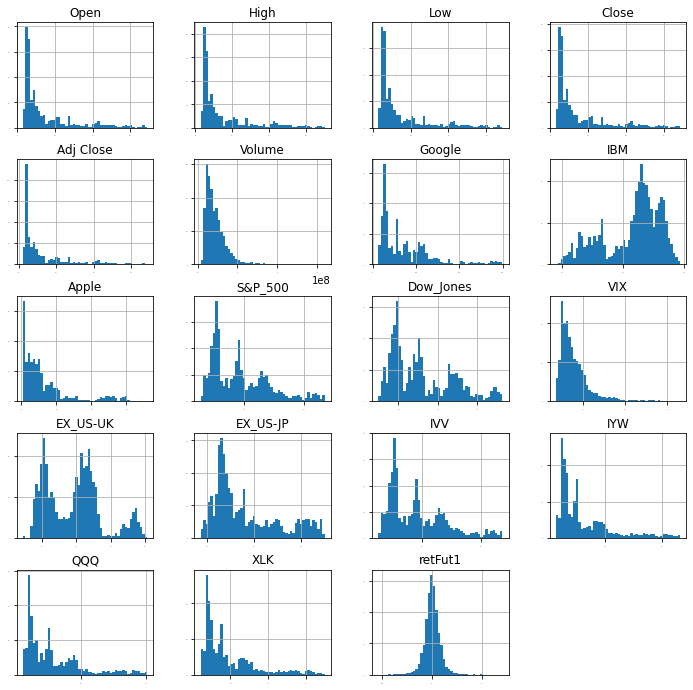

In [ ]:
# Plotting histogram for the features 
df.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually. Further, it can be deduced as how the frequency of the different features affecting the predicting feature.  Next, lets look at the density distribution over the same x axis scale.

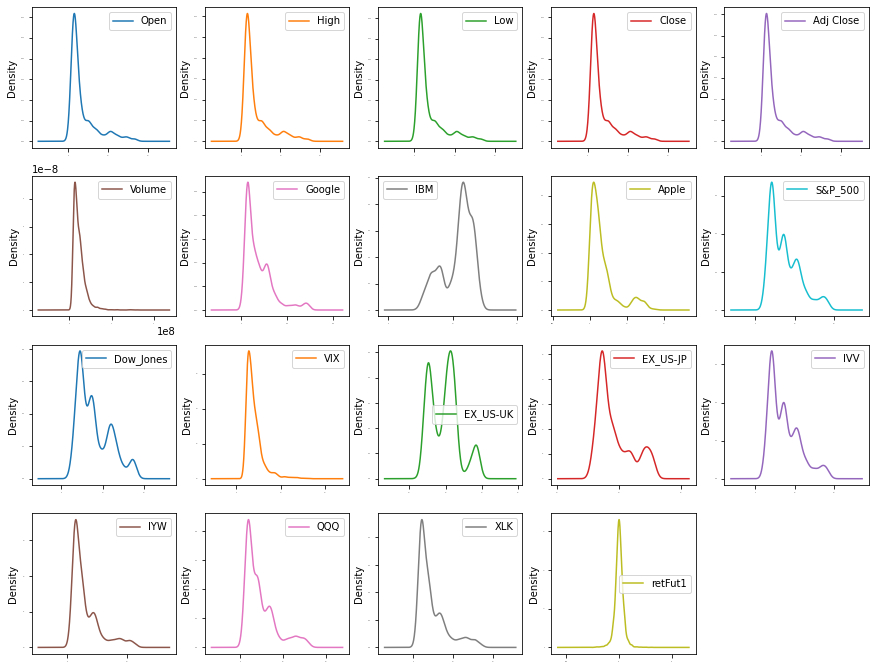

In [ ]:
df.plot(kind='density', subplots=True, layout=(5,5), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that the IBM  has a much larger variance compared to the other company stock distributions.

While, the currency exchange values are much noisy

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

<AxesSubplot:title={'center':'Correlation Matrix'}>

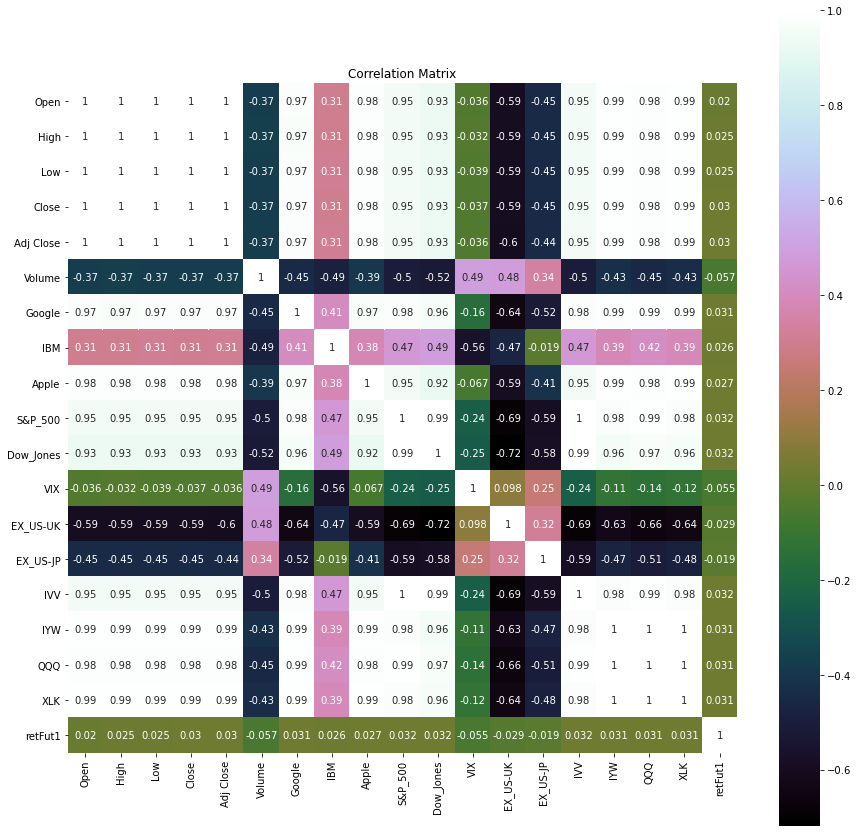

In [ ]:
correlation = df.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted variable with other features. S&P 500, Dow jones, and IVV are having the highest corelation score with the predicted MSFT stock value

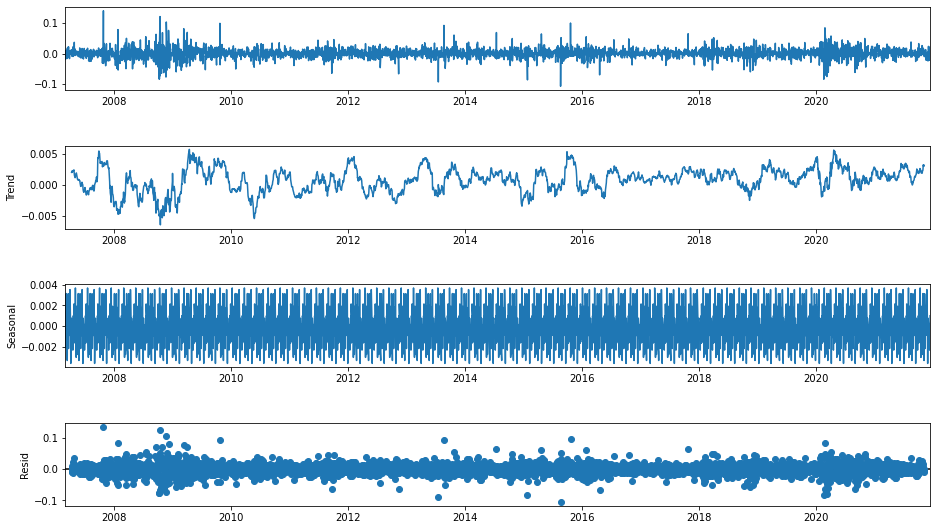

In [ ]:
# Seasonal decomposition of the time series of the predicted feature
res = sm.tsa.seasonal_decompose(y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

By looking at the trend division, it looks like MSFT stock is increasing slighlty each year

# Feature Engineering

There are many different technical indicators that we can use to enhance the signal within the price data, Few of those we are going to use are:

* `Adj. Close Lag` : We will be using few different lags.

* `Momentum Features` : We will be using the momentum features, max number of momentum lag we will use is 10, this feature will help us know the overall trend of the price movement and hopefully allow our model to make predictions on the basis of overall momentum inclination.

* `Exponential Moving Average` : We will be using Exponential Moving Average of `10`, `21`, `65` and `100` as these are some of the most important Exponential Moving Average as per some Stock Market Gurus such as Julian Komar.

* `RSI` : This is one of the most used technical indicators used by many professionals as it provide excellent price divergence indications. we will be using **time frame of 14 days** which is mostly used by professionals.

* `ADX` : This is a great indicator which will help us quantify the strength of the trend our stock is experiencing.

* `Parabolic SAR` : This indicator helps technical traders determine trend direction and potential trend reversal.

In [ ]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 add_lag=True,
                 max_lag=40,
                 lag_step_size=1,
                 add_momentum_features=True,
                 max_momentum_lag=10,
                 add_ewm=True,
                 n_ewm=[10, 21, 65, 100],
                 add_rsi=True,
                 rsi_timeperiod=14,
                 add_adx=True,
                 adx_timeperiod=10,
                 add_sar=True,
                 sar_acceleration=0.2,
                 sar_maximum=0.2,
                 drop_features=True):
        
        self.add_lag = add_lag
        self.max_lag = max_lag
        self.lag_step_size = lag_step_size
        self.add_momentum_features = add_momentum_features
        self.max_momentum_lag = max_momentum_lag
        self.add_ewm = add_ewm
        self.n_ewm = n_ewm
        self.add_rsi = add_rsi
        self.rsi_timeperiod = rsi_timeperiod
        self.add_adx = add_adx
        self.adx_timeperiod = adx_timeperiod
        self.add_sar = add_sar
        self.sar_acceleration = sar_acceleration
        self.sar_maximum = sar_maximum
        self.drop_features = drop_features

        
        
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X, y=None):
        self.close = X['Open'].shift(1)
        self.high = X['High'].shift(1)
        self.low = X['Low'].shift(1)
        
        if self.add_lag:
            for n in range(0, self.max_lag, self.lag_step_size):
                name = 'lag_ret' + str(n)
                X[name] =  X['Open'].pct_change(1).shift(n).fillna(0)
                
        if self.add_momentum_features:
            for n in list(range(1,self.max_momentum_lag)):
                df_period = X.pct_change(periods=n).fillna(0)
                name = 'ret' + str(n)
                X[name] = df_period['Open']
        
        if self.add_ewm:
            
            for n in self.n_ewm:
                name = 'ema_' + str(n)
                X[name] =  X['Open'].ewm(span=n,min_periods=0,adjust=False,ignore_na=False).mean()
                
        if self.add_rsi:
            X['RSI'] = talib.RSI(self.close, timeperiod=self.rsi_timeperiod)
            
        if self.add_adx:
            X['ADX'] = talib.ADX(self.high, self.low, self.close, timeperiod=self.adx_timeperiod)
            
        if self.add_sar:
            X['SAR'] = talib.SAR(self.high, self.low, acceleration=0.2, maximum=0.2)
     
            
        X['Volume'] = np.log(X['Volume'])
        

        X.drop(['High', 'Low', 'Close', 'Adj Close'], axis=1, inplace=True)
            
        return X.fillna(0)
    


In [ ]:
# Adding feature engineering function in to pipeline which can be later used in finding the best estimator to fit in the selected  Random forest model
pipe = Pipeline([('fe', FeatureEngineering(max_lag=50)),
                ('scaler', StandardScaler())])


fe_cols = FeatureEngineering(max_lag=50).transform(X_train.copy()).columns
fe_idx = FeatureEngineering(max_lag=50).transform(X_train.copy()).index

X_train_fe = pd.DataFrame(pipe.fit_transform(X_train.copy()), columns=fe_cols, index=fe_idx)
X_test_fe = pd.DataFrame(pipe.fit_transform(X_test.copy()), columns=fe_cols, index=X_test.index)

# Feature Selection

For Feature selection we have used Both Recursive Feautre Elimination and PCA, They have been applied in the following manner and order:

* `Step 1 - PCA` : First of all PCA was applied, The reason to do so was to drop the extra dimensions using PCA. This step will strengthen the signal and allow for complex non-linear models to fit the data without overfitting it. We have not tried to reduce the dimensionality of the dataset drastically using PCA as it would cause reduction in useful variance in the data other than noise in last few principle components.



* `Step 2 -Recursive Feature Elimination` : Second, to further reduce the dimensionality of the dataset and select features which helped strengthen the signal in the data, hence improving the performance while reducing the dimensionality by dropping less relevant feature engineered features, We use Recursive Feature Elimination technique. Through the learning curve plotted it revealed that we actually observed increase in validation information coefficient by dropping less features deemed less important by Ridge regression, while also reducing overfitting!!

### PCA analysis

In [ ]:
pca = PCA(n_components=X_train_fe.shape[-1])
pca.fit(X_train_fe)

PCA(n_components=80)

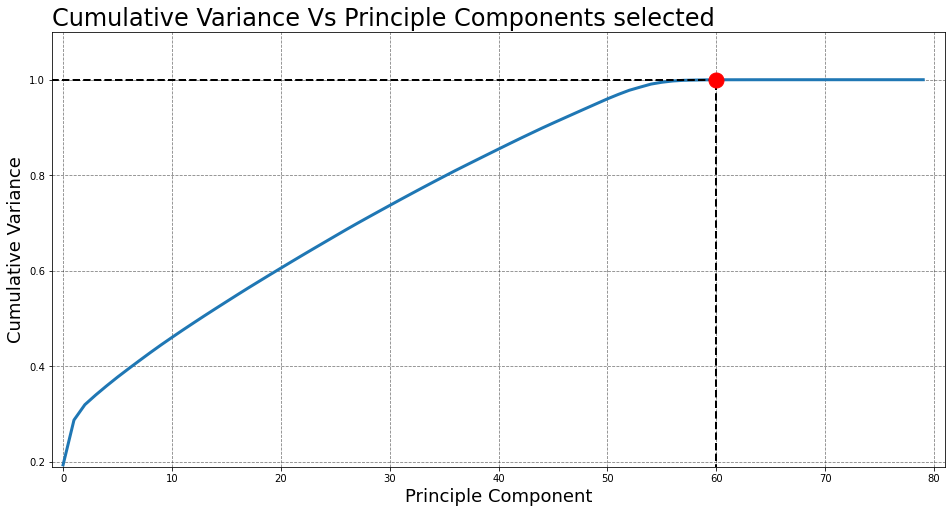

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

REQUIRED_VARIANCE = 0.9997

n = np.argmax(cumulative_variance > REQUIRED_VARIANCE)

plt.figure(figsize=(16, 8))
plt.plot(cumulative_variance, linewidth=3)
plt.plot([n, n], [0, REQUIRED_VARIANCE], color='k', linestyle='--', linewidth=2)
plt.plot([-5, n], [REQUIRED_VARIANCE, REQUIRED_VARIANCE], color='k', linestyle='--', linewidth=2)
plt.plot(n, REQUIRED_VARIANCE, marker='o', color='r', markersize=15)
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.axis([-1, 81, 0.19, 1.1])
plt.title('Cumulative Variance Vs Principle Components selected', fontsize=24, loc='left')
plt.ylabel('Cumulative Variance', fontsize=18)
plt.xlabel('Principle Component', fontsize=18)
plt.show()

**Plot Analysis**: From the above plot it is quite clear that we atleast had 25 out of 80 dimensions in our dataset which was nothing but noise and all the relevant variance in the dataset can be compressed to just 55 dimensions, Hence using the above technique we have dropped the noisy dimensions. This is will allow our Tree ensemble models to fit the data better and avoiding the scenario where they become prone to fitting on noise in the data.

In [ ]:
n_components = X_train_fe.shape[-1]

pipe_pca = Pipeline([('pca', PCA()),
                     ('ridge', Ridge())])

param_grid = {'pca__n_components':range(2, X_train_fe.shape[-1]+1)}

grid = GridSearchCV(pipe_pca, param_grid, cv=TimeSeriesSplit(10), scoring=myscorer_reg, n_jobs=-1, return_train_score=True)
    
grid.fit(X_train_fe, y_train)

results_df = pd.DataFrame(grid.cv_results_)[['params', 'mean_train_score', 'std_train_score', 
                                             'mean_test_score', 'std_test_score']]
results_df['params'] = results_df['params'].map(lambda x : list(x.values())[0])

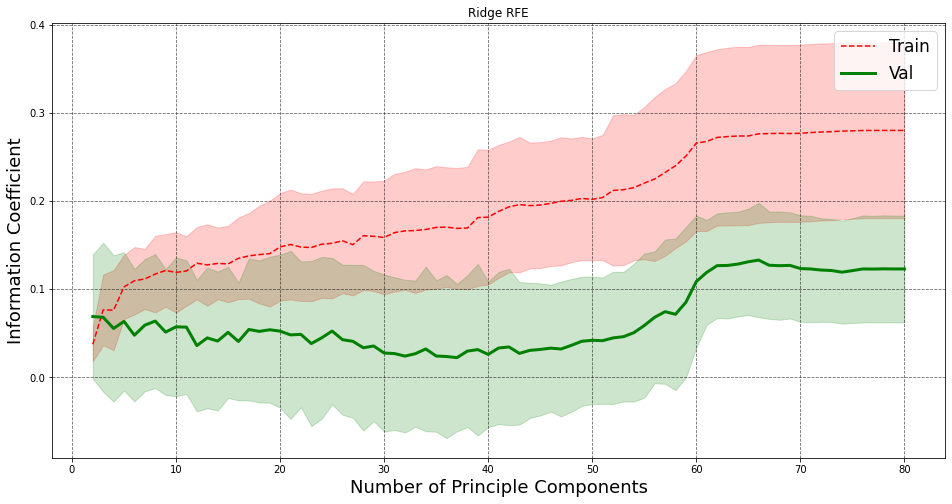

In [ ]:
# Plotting graph for the finding the optimum number of feature required in order to avoid overfitting
upper_bound_train = np.array(results_df['mean_train_score']) + np.array(results_df['std_train_score'])
lower_bound_train = np.array(results_df['mean_train_score']) - np.array(results_df['std_train_score'])
upper_bound_val = np.array(results_df['mean_test_score']) + np.array(results_df['std_test_score'])
lower_bound_val = np.array(results_df['mean_test_score']) - np.array(results_df['std_test_score'])

plt.figure(figsize=(16, 8))
plt.plot(range(2, X_train_fe.shape[-1]+1), np.array(results_df['mean_train_score']), 
         label='Train', color='r', linewidth=1.5, linestyle='--')
plt.plot(range(2, X_train_fe.shape[-1]+1), np.array(results_df['mean_test_score']), 
         label='Val', color='g', linewidth=3)
plt.fill_between(range(2, X_train_fe.shape[-1]+1), y1=lower_bound_train, y2=upper_bound_train, alpha=0.2, color='r')
plt.fill_between(range(2, X_train_fe.shape[-1]+1), y1=lower_bound_val, y2=upper_bound_val, alpha=0.2, color='g')
plt.grid(alpha=0.6, color='k', linestyle='--')
#plt.xticks(ticks=range(0, np.unique(rfe.ranking_)[-1], 1), labels=range(len(X_train_fe.columns), 0, -1), rotation=90)
plt.ylabel('Information Coefficient', fontsize=18)
plt.xlabel('Number of Principle Components', fontsize=18)
plt.title('Ridge RFE')
plt.legend(fontsize=17)
plt.show()

**Plot Analysis**: From the above plot we can clearly see that when we start to remove the principle components we observe and increase in validation score from 80 to 63 Principle components, After that the validation accuracy starts to reduce as we start to drop relevant signal in the dataset. Hence we will compress the dataset down to around 65 dimensions!!

In [ ]:
n_components = 65
pca = PCA(n_components=n_components)
X_train_fe_pca = pd.DataFrame(pca.fit_transform(X_train_fe),
                              columns=[f'component_{i}' for i in range(1, n_components+1)])

X_test_fe_pca = pd.DataFrame(pca.transform(X_test_fe),
                              columns=[f'component_{i}' for i in range(1, n_components+1)])

In [ ]:
def feature_drop_scorer(rfe, X, y, model):
    max_rank = np.max(rfe.ranking_)
    mean_scores_train = []
    std_scores_train = []
    mean_scores_val = []
    std_scores_val = []
    for i in tqdm.tqdm(range(max_rank+1, 1, -1)):
        split = TimeSeriesSplit(n_splits=10)

        scores_train = []
        scores_val = []
        for train_idx, val_idx in split.split(X):
            temp = X.loc[:, rfe.ranking_ < i]
            X_tr, y_tr = temp.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = temp.iloc[val_idx], y.iloc[val_idx]

            model.fit(X_tr, y_tr)
            scores_val.append(myscorer_reg(model, X_val, y_val))
            scores_train.append(myscorer_reg(model, X_tr, y_tr))

        mean_score_train = np.mean(scores_train)
        std_score_train = np.std(scores_train)
        mean_scores_train.append(mean_score_train)
        std_scores_train.append(std_score_train)
        
        mean_score_val = np.mean(scores_val)
        std_score_val = np.std(scores_val)
        mean_scores_val.append(mean_score_val)
        std_scores_val.append(std_score_val)
        
    return mean_scores_train, std_scores_train, mean_scores_val, std_scores_val

def get_features(rfe, X, features_required):
    max_rank = np.max(rfe.ranking_)
    for i in range(max_rank+1, 1, -1):
        cols = X.loc[:, rfe.ranking_ < i].columns
        if len(cols) == features_required:
            return cols
        
    return 'Please enter a valid feature number as per combination searched.'

In [ ]:
rfe = RFE(estimator=Ridge(), n_features_to_select=1, step=1, verbose=1)

rfe.fit(X_train_fe_pca, y_train)

Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 fe

RFE(estimator=Ridge(), n_features_to_select=1, verbose=1)

In [ ]:
# Calling the feature_drop_function to return the values required for calculating the important feature required
mean_scores_train, std_scores_train, mean_scores_val, std_scores_val = feature_drop_scorer(rfe, X_train_fe_pca, y_train, 
                                                                                           Ridge())

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:04<00:00, 13.88it/s]


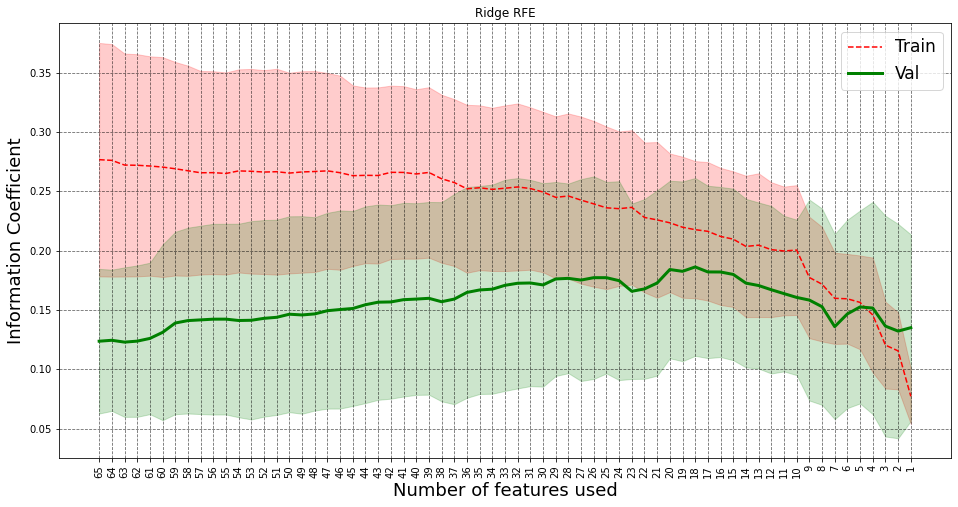

In [ ]:
# Plotting graph for the finding the optimum number of feature required in order to avoid overfitting
upper_bound_train = np.array(mean_scores_train) + np.array(std_scores_train)
lower_bound_train = np.array(mean_scores_train) - np.array(std_scores_train)
upper_bound_val = np.array(mean_scores_val) + np.array(std_scores_val)
lower_bound_val = np.array(mean_scores_val) - np.array(std_scores_val)

plt.figure(figsize=(16, 8))
plt.plot(mean_scores_train, label='Train', color='r', linewidth=1.5, linestyle='--')
plt.plot(mean_scores_val, label='Val', color='g', linewidth=3)
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_train, y2=upper_bound_train, alpha=0.2, color='r')
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_val, y2=upper_bound_val, alpha=0.2, color='g')
plt.grid(alpha=0.6, color='k', linestyle='--')
plt.xticks(ticks=range(0, np.unique(rfe.ranking_)[-1], 1), labels=range(len(X_train_fe_pca.columns), 0, -1), rotation=90)
plt.ylabel('Information Coefficient', fontsize=18)
plt.xlabel('Number of features used', fontsize=18)
plt.title('Ridge RFE')
plt.legend(fontsize=17)
plt.show()

**Plot Analysis**: We can observe from the above plot that as we start to remove the features starting from the least important to more important ones, we observe:
* Constant reduction in Overfitting
* Steady increase in validation score until we are left the 20 most important features.

This shows that out of all the principle components, there exist few which provide most information without providing extra information which might confuse the model into creating a sub optimal regression line!!

Finally rather than selecting 20 best features as per above plot, we will be selecting 30 features, This is because the features selected above are on the basis of importance by ridge regression hence the best features provide most information linearly which can be harnessed by ridge regression efficiently, but non linear model such as tree ensembles might be able to find non linear relation which linear regression could not find, hence we will take few extra top features for tree ensembles to work with.

In [ ]:
# Sacking the selected features
features = get_features(rfe, X_train_fe_pca, features_required=30)

In [ ]:
# List of final features that can be used in wavelet smoothing
features

Index(['component_2', 'component_5', 'component_6', 'component_7',
       'component_8', 'component_13', 'component_14', 'component_15',
       'component_23', 'component_24', 'component_28', 'component_29',
       'component_37', 'component_38', 'component_43', 'component_44',
       'component_49', 'component_52', 'component_54', 'component_55',
       'component_56', 'component_57', 'component_58', 'component_59',
       'component_60', 'component_61', 'component_62', 'component_63',
       'component_64', 'component_65'],
      dtype='object')

In [ ]:
X_train_fe_reduced = X_train_fe_pca.loc[:, features]
X_test_fe_reduced = X_test_fe_pca.loc[:, features]

# Model Implementation

The flow will be like this:
1. Comparing the individual supervised machine learning algorithms (regression vs. classification) for stock price prediction.

2. Grid search for hyperparameter tuning with performance metrics using Time Series Split Cross-Validation for each of the regression and classification algorithms

3. Compare model performance and select the best ones for model stacking


# Regression Approach

### Ridge

In [ ]:
ridge = Ridge() # Defining model type

param_grid_ridge = {'alpha':np.linspace(0.001, 10, 100)} # Putting the hyperparameter feature

grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=TimeSeriesSplit(5), scoring=myscorer_reg, n_jobs=-1, verbose=1) # Execting the gridsearch approach to find the optimal hyperparameter 

grid_ridge.fit(X_train_fe_reduced, y_train) # fitting the parameter as per the training set

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.000e-03, 1.020e-01, 2.030e-01, 3.040e-01, 4.050e-01, 5.060e-01,
       6.070e-01, 7.080e-01, 8.090e-01, 9.100e-01, 1.011e+00, 1.112e+00,
       1.213e+00, 1.314e+00, 1.415e+00, 1.516e+00, 1.617e+00, 1.718e+00,
       1.819e+00, 1.920e+00, 2.021e+00,...
       6.667e+00, 6.768e+00, 6.869e+00, 6.970e+00, 7.071e+00, 7.172e+00,
       7.273e+00, 7.374e+00, 7.475e+00, 7.576e+00, 7.677e+00, 7.778e+00,
       7.879e+00, 7.980e+00, 8.081e+00, 8.182e+00, 8.283e+00, 8.384e+00,
       8.485e+00, 8.586e+00, 8.687e+00, 8.788e+00, 8.889e+00, 8.990e+00,
       9.091e+00, 9.192e+00, 9.293e+00, 9.394e+00, 9.495e+00, 9.596e+00,
       9.697e+00, 9.798e+00, 9.899e+00, 1.000e+01])},
             scoring=make_scorer(information_coefficient), verbose=1)

In [ ]:
# Best parameter output
grid_ridge.best_params_ 

{'alpha': 0.001}

In [ ]:
# Best score output
grid_ridge.best_score_

0.14306430318357002

### Lasso

In [ ]:
lasso = Lasso() # Defining model type

param_grid_lasso = {'alpha':np.logspace(-7, -2, 100)} # Putting the hyperparameter feature

grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=TimeSeriesSplit(5), scoring=myscorer_reg, n_jobs=-1, verbose=1) # Execting the gridsearch approach to find the optimal hyperparameter 

grid_lasso.fit(X_train_fe_reduced, y_train) # fitting the parameter as per the training set

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-07, 1.12332403e-07, 1.26185688e-07, 1.41747416e-07,
       1.59228279e-07, 1.78864953e-07, 2.00923300e-07, 2.25701972e-07,
       2.53536449e-07, 2.84803587e-07, 3.19926714e-07, 3.59381366e-07,
       4.03701726e-07, 4.53487851e-07,...
       1.09749877e-03, 1.23284674e-03, 1.38488637e-03, 1.55567614e-03,
       1.74752840e-03, 1.96304065e-03, 2.20513074e-03, 2.47707636e-03,
       2.78255940e-03, 3.12571585e-03, 3.51119173e-03, 3.94420606e-03,
       4.43062146e-03, 4.97702356e-03, 5.59081018e-03, 6.28029144e-03,
       7.05480231e-03, 7.92482898e-03, 8.90215085e-03, 1.00000000e-02])},
             scoring=make_scorer(information_coefficient), verbose=1)

In [ ]:
# Best parameter output
grid_lasso.best_params_

{'alpha': 1.8307382802953698e-06}

In [ ]:
# Best score output
grid_lasso.best_score_

0.1433993778979989

### SVR

In [ ]:
SVR = LinearSVR() # Defining model type

param_grid_svr = {'C':np.linspace(0.0005, 1, 100),
                  'epsilon':[0.0]}  # Putting the hyperparameter feature

grid_svr = GridSearchCV(SVR, param_grid_svr, cv=TimeSeriesSplit(5), scoring=myscorer_reg, n_jobs=-1, verbose=1) # Execting the gridsearch approach to find the optimal hyperparameter 

grid_svr.fit(X_train_fe_reduced, y_train) # fitting the parameter as per the training set

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearSVR(), n_jobs=-1,
             param_grid={'C': array([5.00000000e-04, 1.05959596e-02, 2.06919192e-02, 3.07878788e-02,
       4.08838384e-02, 5.09797980e-02, 6.10757576e-02, 7.11717172e-02,
       8.12676768e-02, 9.13636364e-02, 1.01459596e-01, 1.11555556e-01,
       1.21651515e-01, 1.31747475e-01,...
       8.08176768e-01, 8.18272727e-01, 8.28368687e-01, 8.38464646e-01,
       8.48560606e-01, 8.58656566e-01, 8.68752525e-01, 8.78848485e-01,
       8.88944444e-01, 8.99040404e-01, 9.09136364e-01, 9.19232323e-01,
       9.29328283e-01, 9.39424242e-01, 9.49520202e-01, 9.59616162e-01,
       9.69712121e-01, 9.79808081e-01, 9.89904040e-01, 1.00000000e+00]),
                         'epsilon': [0.0]},
             scoring=make_scorer(information_coefficient), verbose=1)

In [ ]:
# Best parameter output
grid_svr.best_params_

{'C': 0.10145959595959596, 'epsilon': 0.0}

In [ ]:
# Best score output
grid_svr.best_score_

0.14456636926283473

### NuSVR

In [ ]:
nusvr = NuSVR() # Defining model type

param_grid_nusvr = {'nu':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5],    
                    'C':np.linspace(0.005, 0.08, 50),
                    'kernel':['linear']}    # Putting the hyperparameter feature

grid_nusvr = GridSearchCV(nusvr, param_grid_nusvr, cv=TimeSeriesSplit(n_splits=5), scoring=myscorer_reg, n_jobs=-1, verbose=10)   # Execting the gridsearch approach to find the optimal hyperparameter 

grid_nusvr.fit(X_train_fe_reduced, y_train)   # fitting the parameter as per the training set

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': array([0.005     , 0.00653061, 0.00806122, 0.00959184, 0.01112245,
       0.01265306, 0.01418367, 0.01571429, 0.0172449 , 0.01877551,
       0.02030612, 0.02183673, 0.02336735, 0.02489796, 0.02642857,
       0.02795918, 0.0294898 , 0.03102041, 0.03255102, 0.03408163,
       0...
       0.04326531, 0.04479592, 0.04632653, 0.04785714, 0.04938776,
       0.05091837, 0.05244898, 0.05397959, 0.0555102 , 0.05704082,
       0.05857143, 0.06010204, 0.06163265, 0.06316327, 0.06469388,
       0.06622449, 0.0677551 , 0.06928571, 0.07081633, 0.07234694,
       0.07387755, 0.07540816, 0.07693878, 0.07846939, 0.08      ]),
                         'kernel': ['linear'],
                         'nu': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
             scoring=make_scorer(information_coefficient), verbose=10)

In [ ]:
# Best parameter output
grid_nusvr.best_params_

{'C': 0.06775510204081633, 'kernel': 'linear', 'nu': 0.3}

In [ ]:
# Best score output
grid_nusvr.best_score_

0.1508225002934153

### KNeighborsRegressor

In [ ]:
knnr = KNeighborsRegressor() # Defining model type

param_grid_knnr = {'n_neighbors':[i for i in range(1, 100)]}  # Putting the hyperparameter feature

grid_knnr = GridSearchCV(knnr, param_grid_knnr, cv=TimeSeriesSplit(n_splits=5), scoring=myscorer_reg, n_jobs=-1, verbose=1)   # Execting the gridsearch approach to find the optimal hyperparameter 

grid_knnr.fit(X_train_fe_reduced, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring=make_scorer(information_coefficient), verbose=1)

In [ ]:
# Best parameter output
grid_knnr.best_params_

{'n_neighbors': 88}

In [ ]:
# Best score output
grid_knnr.best_score_

0.04389737728489818

### DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor() # Defining model type

param_grid_dtr = {'max_depth':[i for i in range(3, 20)] + [None],
                  'min_samples_split':[i for i in range(2, 10)]}    # Putting the hyperparameter feature

grid_dtr = GridSearchCV(dtr, param_grid_dtr, cv=TimeSeriesSplit(n_splits=5), scoring=myscorer_reg, n_jobs=-1, verbose=1)    # Execting the gridsearch approach to find the optimal hyperparameter 

grid_dtr.fit(X_train_fe_reduced, y_train)   # fitting the parameter as per the training set

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, None],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring=make_scorer(information_coefficient), verbose=1)

In [ ]:
# Best parameter output
grid_dtr.best_params_

{'max_depth': 4, 'min_samples_split': 3}

In [ ]:
# Best score output
grid_dtr.best_score_

0.06079756781255956

### RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor() # Defining model type

param_grid_rfr = {'n_estimators':[700],
                  'min_samples_split':[ 5, 7, 9, 13],
                  'max_features':[0.5, 0.8, 1.0],
                  'max_depth':[5, 7, 9]
                  }       # Putting the hyperparameter feature

grid_rfr = RandomizedSearchCV(rfr, param_grid_rfr, cv=TimeSeriesSplit(n_splits=5), n_iter=30, scoring=myscorer_reg, n_jobs=-1, verbose=1)   # Execting the gridsearch approach to find the optimal hyperparameter 

grid_rfr.fit(X_train_fe_reduced, y_train)   # fitting the parameter as per the training set

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9],
                                        'max_features': [0.5, 0.8, 1.0],
                                        'min_samples_split': [5, 7, 9, 13],
                                        'n_estimators': [700]},
                   scoring=make_scorer(information_coefficient), verbose=1)

In [ ]:
# Best parameter output
grid_rfr.best_params_

{'n_estimators': 700,
 'min_samples_split': 9,
 'max_features': 0.5,
 'max_depth': 5}

In [ ]:
# Best score output
grid_rfr.best_score_

0.11172211049837596

### ExtraTreesRegressor

In [ ]:
etr = ExtraTreesRegressor() # Defining model type

param_grid_etr = {'n_estimators':[800],
                  'min_samples_split':[5, 7, 9, 13],
                  'max_features':[0.5, 0.8, 1.0],
                  'max_depth':[5, 7, 9]}      # Putting the hyperparameter feature

grid_etr = RandomizedSearchCV(etr, param_grid_etr, cv=TimeSeriesSplit(n_splits=5), n_iter=30, scoring=myscorer_reg, n_jobs=-1, verbose=1)   # Execting the gridsearch approach to find the optimal hyperparameter 

grid_etr.fit(X_train_fe_reduced, y_train)   # fitting the parameter as per the training set

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=ExtraTreesRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9],
                                        'max_features': [0.5, 0.8, 1.0],
                                        'min_samples_split': [5, 7, 9, 13],
                                        'n_estimators': [800]},
                   scoring=make_scorer(information_coefficient), verbose=1)

In [ ]:
# Best parameter output
grid_etr.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'max_features': 0.5,
 'max_depth': 5}

In [ ]:
# Best score output
grid_etr.best_score_

0.13730123945218528

### GradientBoostingRegressor

In [ ]:
gbtr = GradientBoostingRegressor() # Defining model type

param_grid_gbtr = {'n_estimators':[100, 200, 400, 600, 1000],
                   'max_depth':[3],
                   'max_features':[0.3, 0.5, 0.7],
                   'min_samples_split':[5, 7, 9, 13],}      # Putting the hyperparameter feature

grid_gbtr = GridSearchCV(gbtr, param_grid_gbtr, cv=TimeSeriesSplit(n_splits=5), scoring=myscorer_reg, n_jobs=-1, verbose=1)   # Execting the gridsearch approach to find the optimal hyperparameter 

grid_gbtr.fit(X_train_fe_reduced, y_train)    # fitting the parameter as per the training set

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3], 'max_features': [0.3, 0.5, 0.7],
                         'min_samples_split': [5, 7, 9, 13],
                         'n_estimators': [100, 200, 400, 600, 1000]},
             scoring=make_scorer(information_coefficient), verbose=1)

In [ ]:
# Best parameter output
grid_gbtr.best_params_

{'max_depth': 3,
 'max_features': 0.5,
 'min_samples_split': 13,
 'n_estimators': 100}

In [ ]:
# Best score output
grid_gbtr.best_score_

0.11543852446200453

### XGBRegressor

In [ ]:
xgbr = XGBRegressor() # Defining model type

param_grid_xgbr = {'learning_rate':[0.05, 0.1],
                   'n_estimators':[500, 1000, 1100, 1200],
                   'max_depth':[3, 4, 5],
                   'max_features':[0.3, 0.5, 0.7, 0.9],
                   'min_samples_split':[5, 7, 9, 13]}    # Putting the hyperparameter feature

grid_xgbr = RandomizedSearchCV(xgbr, param_grid_xgbr, cv=TimeSeriesSplit(n_splits=5), n_iter=50, scoring=myscorer_reg, n_jobs=-1, verbose=1) # Execting the gridsearch approach to find the optimal hyperparameter 

grid_xgbr.fit(X_train_fe_reduced, y_train)    # fitting the parameter as per the training set

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[12:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { max_features, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_w...
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
       

In [ ]:
# Best parameter output
grid_xgbr.best_params_

{'n_estimators': 1200,
 'min_samples_split': 9,
 'max_features': 0.7,
 'max_depth': 5,
 'learning_rate': 0.05}

In [ ]:
# Best score output
grid_xgbr.best_score_

0.11760137616228863

# Classification Approach

### LogisticRegression

In [ ]:
logreg = LogisticRegression()  # Defining model type


param_grid_logreg = {'C':np.linspace(0.01, 1, 100)}   # Putting the hyperparameter feature

grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=TimeSeriesSplit(5), scoring='accuracy', n_jobs=1, verbose=1) # Execting the gridsearch approach to find the optimal hyperparameter 

grid_logreg.fit(X_train_fe_reduced, yc_train)   # fitting the parameter as per the training set

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(), n_jobs=1,
             param_grid={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='accuracy', verbose=1)

In [ ]:
# Best parameter output
grid_logreg.best_params_

{'C': 0.14}

In [ ]:
# Best score output
grid_logreg.best_score_

0.5456740442655936

### DecisionTreeClassifier

In [ ]:
dtc = DecisionTreeClassifier()  # Defining model type

param_grid_dtc = {'max_depth':[i for i in range(3, 20)] + [None],
                  'min_samples_split':[i for i in range(2, 10)]}    # Putting the hyperparameter feature

grid_dtc = GridSearchCV(dtc, param_grid_dtc, cv=TimeSeriesSplit(5), scoring='accuracy', n_jobs=-1, verbose=1) # Execting the gridsearch approach to find the optimal hyperparameter 

grid_dtc.fit(X_train_fe_reduced, yc_train)    # fitting the parameter as per the training set

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, None],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy', verbose=1)

In [ ]:
# Best parameter output
grid_dtc.best_params_

{'max_depth': 3, 'min_samples_split': 2}

In [ ]:
# Best score output
grid_dtc.best_score_

0.5311871227364185

### LinearSVC

In [ ]:
svc = LinearSVC()     # Defining model type

param_grid_svc = {'C':np.linspace(0.05, 1, 100)}   # Putting the hyperparameter feature

grid_svc = GridSearchCV(svc, param_grid_svc, cv=TimeSeriesSplit(5), scoring='accuracy', n_jobs=-1, verbose=1)   # Execting the gridsearch approach to find the optimal hyperparameter 

grid_svc.fit(X_train_fe_reduced, yc_train)    # fitting the parameter as per the training set

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([0.05      , 0.05959596, 0.06919192, 0.07878788, 0.08838384,
       0.0979798 , 0.10757576, 0.11717172, 0.12676768, 0.13636364,
       0.1459596 , 0.15555556, 0.16515152, 0.17474747, 0.18434343,
       0.19393939, 0.20353535, 0.21313131, 0.22272727, 0.2323232...
       0.72171717, 0.73131313, 0.74090909, 0.75050505, 0.76010101,
       0.76969697, 0.77929293, 0.78888889, 0.79848485, 0.80808081,
       0.81767677, 0.82727273, 0.83686869, 0.84646465, 0.85606061,
       0.86565657, 0.87525253, 0.88484848, 0.89444444, 0.9040404 ,
       0.91363636, 0.92323232, 0.93282828, 0.94242424, 0.9520202 ,
       0.96161616, 0.97121212, 0.98080808, 0.99040404, 1.        ])},
             scoring='accuracy', verbose=1)

In [ ]:
# Best parameter output
grid_svc.best_params_

{'C': 0.76010101010101}

In [ ]:
# Best score output
grid_svc.best_score_

0.5484909456740443

### NuSVC

In [ ]:
nusvc = NuSVC()   # Defining model type

param_grid_nusvc = {'nu':np.linspace(0.01, 1.0),
                    'kernel':['linear']}      # Putting the hyperparameter feature

grid_nusvc = GridSearchCV(nusvc, param_grid_nusvc,  cv=TimeSeriesSplit(5), scoring='accuracy', n_jobs=-1, verbose=1)    # Execting the gridsearch approach to find the optimal hyperparameter 

grid_nusvc.fit(X_train_fe_reduced, yc_train)    # fitting the parameter as per the training set

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=NuSVC(), n_jobs=-1,
             param_grid={'kernel': ['linear'],
                         'nu': array([0.01      , 0.03020408, 0.05040816, 0.07061224, 0.09081633,
       0.11102041, 0.13122449, 0.15142857, 0.17163265, 0.19183673,
       0.21204082, 0.2322449 , 0.25244898, 0.27265306, 0.29285714,
       0.31306122, 0.33326531, 0.35346939, 0....
       0.41408163, 0.43428571, 0.4544898 , 0.47469388, 0.49489796,
       0.51510204, 0.53530612, 0.5555102 , 0.57571429, 0.59591837,
       0.61612245, 0.63632653, 0.65653061, 0.67673469, 0.69693878,
       0.71714286, 0.73734694, 0.75755102, 0.7777551 , 0.79795918,
       0.81816327, 0.83836735, 0.85857143, 0.87877551, 0.89897959,
       0.91918367, 0.93938776, 0.95959184, 0.97979592, 1.        ])},
             scoring='accuracy', verbose=1)

In [ ]:
# Best parameter output
grid_nusvc.best_params_

{'kernel': 'linear', 'nu': 0.9191836734693878}

In [ ]:
# Best score output
grid_nusvc.best_score_

0.5360160965794769

### KNeighborsClassifier

In [ ]:
knnc = KNeighborsClassifier()   # Defining model type

param_grid_knnc = {'n_neighbors':[i for i in range(1, 100)]}    # Putting the hyperparameter feature

grid_knnc = GridSearchCV(knnc, param_grid_knnc,  cv=TimeSeriesSplit(5), scoring='accuracy', n_jobs=-1, verbose=1)   # Execting the gridsearch approach to find the optimal hyperparameter 

grid_knnc.fit(X_train_fe_reduced, yc_train)   # fitting the parameter as per the training set

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy', verbose=1)

In [ ]:
# Best parameter output
grid_knnc.best_params_

{'n_neighbors': 17}

In [ ]:
# Best score output
grid_knnc.best_score_

0.5275653923541248

### RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier()    # Defining model type

param_grid_rfc = {'n_estimators':[700],
                  'min_samples_split':[5, 7, 9, 13],
                  'max_features':[0.5, 0.8, 1.0],
                  'max_depth':[5, 6, 7]
                  }     # Putting the hyperparameter feature

grid_rfc = GridSearchCV(rfc, param_grid_rfc,  cv=TimeSeriesSplit(5), scoring='accuracy', n_jobs=-1, verbose=1)    # Execting the gridsearch approach to find the optimal hyperparameter 

grid_rfc.fit(X_train_fe_reduced, yc_train)    # fitting the parameter as per the training set

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7],
                         'max_features': [0.5, 0.8, 1.0],
                         'min_samples_split': [5, 7, 9, 13],
                         'n_estimators': [700]},
             scoring='accuracy', verbose=1)

In [ ]:
# Best parameter output
grid_rfc.best_params_

{'max_depth': 6,
 'max_features': 0.5,
 'min_samples_split': 5,
 'n_estimators': 700}

In [ ]:
# Best score output
grid_rfc.best_score_

0.5440643863179074

### ExtraTreesClassifier

In [ ]:
etc = ExtraTreesClassifier()    # Defining model type

param_grid_etc = {'n_estimators':[800],
                  'min_samples_split':[5, 7, 9, 13],
                  'max_features':[0.7, 0.8, 1.0],
                  'max_depth':[5, 6, 7]
                  }   # Putting the hyperparameter feature

grid_etc = GridSearchCV(etc, param_grid_etc, cv=TimeSeriesSplit(5), scoring='accuracy', n_jobs=-1, verbose=1)   # Execting the gridsearch approach to find the optimal hyperparameter 

grid_etc.fit(X_train_fe_reduced, yc_train)    # fitting the parameter as per the training set

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7],
                         'max_features': [0.7, 0.8, 1.0],
                         'min_samples_split': [5, 7, 9, 13],
                         'n_estimators': [800]},
             scoring='accuracy', verbose=1)

In [ ]:
# Best parameter output
grid_etc.best_params_

{'max_depth': 6,
 'max_features': 0.8,
 'min_samples_split': 7,
 'n_estimators': 800}

In [ ]:
# Best score output
grid_etc.best_score_

0.532394366197183

### GradientBoostingClassifier

In [ ]:
gbtc = GradientBoostingClassifier()   # Defining model type

param_grid_gbtc = {'n_estimators':[100, 200, 400, 600, 1000],
                   'max_depth':[3],
                   'max_features':[0.3, 0.5, 0.7],
                   'min_samples_split':[5, 7, 9, 13],}    # Putting the hyperparameter feature

grid_gbtc = RandomizedSearchCV(gbtc, param_grid_gbtc,  cv=TimeSeriesSplit(5), n_iter=50, 
                               scoring='accuracy', n_jobs=-1, verbose=1)    # Execting the gridsearch approach to find the optimal hyperparameter 

grid_gbtc.fit(X_train_fe_reduced, yc_train)   # fitting the parameter as per the training set

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=GradientBoostingClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [3],
                                        'max_features': [0.3, 0.5, 0.7],
                                        'min_samples_split': [5, 7, 9, 13],
                                        'n_estimators': [100, 200, 400, 600,
                                                         1000]},
                   scoring='accuracy', verbose=1)

In [ ]:
# Best parameter output
grid_gbtc.best_params_

{'n_estimators': 100,
 'min_samples_split': 13,
 'max_features': 0.3,
 'max_depth': 3}

In [ ]:
# Best score output
grid_gbtc.best_score_

0.538430583501006

### XGBClassifier

In [ ]:
xgbc = XGBClassifier()    # Defining model type

param_grid_xgbc = {'learning_rate':[0.05, 0.1],
                   'n_estimators':[500, 1000, 1100, 1200],
                   'max_depth':[3, 4, 5, 6, 7],
                   'max_features':[0.3, 0.5, 0.7],
                  'min_samples_split':[5, 7, 9, 13]}    # Putting the hyperparameter feature

grid_xgbc = RandomizedSearchCV(xgbc, param_grid_xgbc, cv=TimeSeriesSplit(5), n_iter=50, 
                               scoring='accuracy', n_jobs=-1, verbose=1)      # Execting the gridsearch approach to find the optimal hyperparameter 

grid_xgbc.fit(X_train_fe_reduced, yc_train)   # fitting the parameter as per the training set

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[13:01:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { max_features, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:01:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree

In [ ]:
# Best parameter output
grid_xgbc.best_params_

{'n_estimators': 1100,
 'min_samples_split': 13,
 'max_features': 0.7,
 'max_depth': 7,
 'learning_rate': 0.1}

In [ ]:
# Best score output
grid_xgbc.best_score_

0.5356136820925553

## Stacking ensemble

**Why use stacking?**

In Stacking ensembling technique we have the base models which are usually different in the following sense:

Different datasets used for same machine learning model
Different good parameter set used for same machine learning model
Different machine leanring models used.
Predictions from these base models are used as training dataset for the meta model or the final aggregating model, This model trains to generalize the result by focusing on machine learning models which are best predicting a particular sample more and focusing less on them in the case where they are not confident in predicting a certain type of sample.

Hence Stacking is a way of generalize the result and impore them at the same time by aggregating the Pros of different models!!

### Regression Stack

For regression stack we will not be using Tree ensembles as they are overfitting compared to other models and the best stacking results are observed when we used the following base models

In [ ]:
estimators_list = [('ridge', grid_ridge.best_estimator_), 
                   ('lasso', grid_lasso.best_estimator_), 
                   ('svr', grid_svr.best_estimator_),
                   ('nusvr', grid_nusvr.best_estimator_),
                   ('dtr', grid_dtr.best_estimator_),
                   ('knnr', grid_knnr.best_estimator_)
                  ]

stack_reg = StackingRegressor(estimators=estimators_list, n_jobs=-1)

stack_reg.fit(X_train_fe_reduced, y_train)  # fitting the parameter as per the training set

StackingRegressor(estimators=[('ridge', Ridge(alpha=0.001)),
                              ('lasso', Lasso(alpha=1.8307382802953698e-06)),
                              ('svr', LinearSVR(C=0.10145959595959596)),
                              ('nusvr',
                               NuSVR(C=0.06775510204081633, kernel='linear',
                                     nu=0.3)),
                              ('dtr',
                               DecisionTreeRegressor(max_depth=4,
                                                     min_samples_split=3)),
                              ('knnr', KNeighborsRegressor(n_neighbors=88))],
                  n_jobs=-1)

In [ ]:
# Score value on the traning set
myscorer_reg(stack_reg, X_train_fe_reduced, y_train)

0.22874319283113223

In [ ]:
# Score value on the testing set
myscorer_reg(stack_reg, X_test_fe_reduced, y_test)

0.17173523914999106

### Classification Stack

In [ ]:
estimators_list = [('logreg', grid_logreg.best_estimator_), 
                   ('svc', grid_svc.best_estimator_),
                   ('nusvc', grid_nusvc.best_estimator_)
                  ]

stack_classifier = StackingClassifier(estimators=estimators_list, n_jobs=-1)

stack_classifier.fit(X_train_fe_reduced, yc_train)    # fitting the parameter as per the training set

StackingClassifier(estimators=[('logreg', LogisticRegression(C=0.14)),
                               ('svc', LinearSVC(C=0.76010101010101)),
                               ('nusvc',
                                NuSVC(kernel='linear', nu=0.9191836734693878))],
                   n_jobs=-1)

In [ ]:
# Score value on the traning set
accuracy_score(yc_train, stack_classifier.predict(X_train_fe_reduced))

0.5650570087189806

In [ ]:
# Score value on the testing set
accuracy_score(yc_test, stack_classifier.predict(X_test_fe_reduced))

0.5764075067024129

# Evaluation Metrics

'result' function will be usde to evaluate the performances of the different model executed earlier. 

1. It will give the following values for the regression approach:
cagr_train, cagr_test, Sharpe_ratio_train, Sharpe_ratio_test, spearman_rho, spearman_pval and Ljung-Box test p-value

2. It will give the following values for the classification approach:
cagr_train, cagr_test, Sharpe_ratio_train, Sharpe_ratio_test, phik_k_corr, phik_k_p_val, accuracy and Ljung-Box test p-value


In [ ]:
def result(models, x_train, x_test, y_test, task_type='Regression'):
    '''This Function Gives the final result for all the model with best parameters found on the basis of task type.
       models : Dictionary containing name of the machine learning model as key and fitted model/grid object as value
       task_type : to be specified depending upon the machine learning model passed.
    '''
    
    result_summary = {}
    model_list = list(models.keys())
  
    for i, name in enumerate(model_list):
        result = []
        grid = models[name]
        
        #Make "predictions" on training set (in-sample)
        positions = np.where(grid.predict(x_train)> 0,1,-1 )
        dailyRet = pd.Series(positions.reshape(-1)).fillna(0).values * retFut1_train 
        dailyRet = dailyRet.fillna(0)
        cumret = np.cumprod(dailyRet + 1) - 1
        
        #Make "predictions" on test set (out-sample)
        positions2 = np.where(grid.predict(x_test)> 0,1,-1 )
        dailyRet2 = pd.Series(positions2.reshape(-1)).fillna(0).values * retFut1_test
        dailyRet2 = dailyRet2.fillna(0)
        cumret2 = np.cumprod(dailyRet2 + 1) - 1
        
        # Compound Annual Growth Rate - Training
        cagr_train = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
        
        # Compound Annual Growth Rate - Test
        cagr_test = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
        
        # Sharpe Ratio - Training
        ratio_train = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
        
        # Sharpe Ratio - Test
        ratio_test = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
    
        
        if task_type == 'Regression':

            #metrics
            rho, pval = spearmanr(y_test,grid.predict(x_test).reshape(-1)) 
            #spearman's rank correlation: very small but significant

            #residuals
            true_y = y_test.values.ravel()
            pred_y = grid.predict(x_test).reshape(-1)
            residuals = np.subtract(true_y, pred_y)

            #Residual autocorrelation
            #If the p-value of the test is greater than the required significance (>0.05), residuals are independent
            lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
            #print("Ljung-Box test p-value", lb[1])

            result.extend((cagr_train,cagr_test,ratio_train, ratio_test, rho, pval, lb[1]))
            result_summary.update({name:result})
    
            cols = ['cagr_train', 'cagr_test', 
                    'Sharpe_ratio_train', 'Sharpe_ratio_test',
                    'spearman_rho', 'spearman_pval',
                    'Ljung-Box test p-value']
            
    
        elif task_type == 'Classification':

            #metrics
            acc = accuracy_score(y_test.values.ravel(), grid.predict(x_test).reshape(-1))

            arr1 = y_test.values.ravel()
            arr2 = grid.predict(x_test).reshape(-1)
            dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
            phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
            significance_overview = dfc.significance_matrix(interval_cols=[])
            phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
            phi_k_p_val = 1 - ndtr(phi_k_sig)

            #residuals
            true_y = y_test.values.ravel()
            pred_y = grid.predict(x_test).reshape(-1)
            residuals = np.subtract(true_y, pred_y)

            #Residual autocorrelation
            #If the p-value of the test is greater than the required significance (>0.05), residuals are independent
            lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
            #print("Ljung-Box test p-value", lb[1])

            result.extend((cagr_train,cagr_test,ratio_train, ratio_test, phi_k_corr, phi_k_p_val, acc, lb[1]))
            result_summary.update({name:result})


            cols = ['cagr_train', 'cagr_test', 
                    'Sharpe_ratio_train', 'Sharpe_ratio_test',
                    'phik_k_corr', 'phik_k_p_val',
                    'accuracy',
                    'Ljung-Box test p-value']
                                 
    summary_df = pd.DataFrame.from_dict(result_summary, 
                                            orient='index',
                                            columns = cols)
            
    return summary_df

In [ ]:
# Calling the redult function as defined above
result({'Ridge':grid_ridge,
        'lasso':grid_lasso,
        'SVR':grid_svr,
        'NuSVR':grid_nusvr,
        'KNeighborsRegressor':grid_knnr,
        'DecisionTreeRegressor':grid_dtr,
        'RandomForestRegressor':grid_rfr,
        'ExtraTreesRegressor':grid_etr,
        'GradientBoostingRegressor':grid_gbtr,
        'XGBRegressor':grid_xgbr,
        'StackingRegressor':stack_reg
       },
        X_train_fe_reduced, X_test_fe_reduced, y_test, task_type='Regression')

,cagr_train,cagr_test,Sharpe_ratio_train,Sharpe_ratio_test,spearman_rho,spearman_pval,Ljung-Box test p-value
Ridge,0.964901,0.765440,2.753326,2.290680,0.158819,1.311124e-05,[1.5921682430835313e-11]
lasso,0.987075,0.858335,2.798134,2.489826,0.160896,1.005459e-05,[8.765776764436348e-10]
SVR,0.820457,0.675488,2.450043,2.088801,0.179450,8.089207e-07,[0.0045870374470038675]
NuSVR,0.926044,0.629712,2.674403,1.982536,0.135009,2.170779e-04,[4.2663500195742726e-18]
KNeighborsRegressor,0.731312,0.557159,2.250810,1.807756,0.097839,7.490417e-03,[0.10471384224246749]
DecisionTreeRegressor,0.696413,0.716088,2.170618,2.180821,0.110280,2.559405e-03,[4.333227242079784e-31]
RandomForestRegressor,1.417658,0.522391,3.593500,1.720924,0.143745,8.148224e-05,[1.7069875889337248e-05]
ExtraTreesRegressor,1.598954,0.569874,3.893455,1.838499,0.162179,8.519995e-06,[0.38360375271467134]
GradientBoostingRegressor,3.652729,0.559988,6.491388,1.814532,0.164066,6.662735e-06,[2.373400325754841e-24]
XGBRegressor,15.537633,0.717656,14.886532,2.184510,0.123460,7.266192e-04,[1.3820811531726574e-75]


Stacking the models helped us gain higher cagr and sharpe ratio!!

In [ ]:
result({'LogisticRegression':grid_logreg,
        'SVC':grid_svc,
        'NuSVC':grid_nusvc,
        'KNeighborsClassifier':grid_knnc,
        'DecisionTreeClassifier':grid_dtc,
        'RandomForestClassifier':grid_rfc,
        'ExtraTreesClassifier':grid_etc,
        'GradientBoostingClassifier':grid_gbtc,
        'XGBClassifier':grid_xgbc,
        'StackingClassifier':stack_classifier
       },
        X_train_fe_reduced, X_test_fe_reduced, yc_test, task_type='Classification')

,cagr_train,cagr_test,Sharpe_ratio_train,Sharpe_ratio_test,phik_k_corr,phik_k_p_val,accuracy,Ljung-Box test p-value
LogisticRegression,0.666752,0.492927,2.102699,1.646266,0.146237,0.005681,0.558981,[2.717245541737764e-110]
SVC,0.988956,0.632232,2.802104,1.988064,0.155613,0.003067,0.563003,[3.5428867430409747e-125]
NuSVC,0.820609,0.733630,2.450162,2.220161,0.156317,0.003042,0.565684,[9.983196034726775e-80]
KNeighborsClassifier,0.952654,0.335675,2.728721,1.223283,0.000000,0.898954,0.512064,[0.21513755735286016]
DecisionTreeClassifier,0.735668,0.769186,2.260793,2.298961,0.101994,0.035956,0.549598,[1.0882638453870356e-127]
RandomForestClassifier,6.962196,0.758833,9.360892,2.276533,0.144110,0.004969,0.557641,[5.000288103111597e-105]
ExtraTreesClassifier,3.977552,0.755834,6.820904,2.269469,0.173284,0.001020,0.564343,[3.0114754826141064e-101]
GradientBoostingClassifier,4.472177,0.213822,7.295797,0.861653,0.071087,0.100842,0.514745,[1.6016877680008657e-36]
XGBClassifier,15.741176,0.319405,15.007778,1.177290,0.113968,0.021655,0.538874,[5.844783937575798e-28]
StackingClassifier,0.857676,1.224637,2.529706,3.198594,0.183463,0.000566,0.576408,[2.5379986325709776e-121]


#### Analysis : We can infer following from the above final results on training and testing dataset using the best parameters:

1. Tree Ensembles : We can observe that tree ensembles have a tendency to overfit which is worse with the Gradient boosting trees, The difference can be observed in the high cagr and sharpe ratio observed for training compared to low cagr and sharpe for testing in comparison. This is because the gradient boosting trees can easily overfit the data, the dataset we are using makes it worse as it is stock price dataset which can have lots of similar kind of noise in the training data dependent on time frames which might not be present in the testing data. This is because There might be some forces in stock market which were influencing the stock price at some point of time but may not be present in time steps in future. This fact makes it difficult for models which are prone to overfitting to find a good parameter set using which it can generalize to the testing data as well. 

2. Linear Models : Contrary to the case of tree ensembles, linear models are giving us excellent results, they are not overfitting and the cagr and sharpe ratio we observe are similar to that in test, Plus we can also observe that the sharpe ratio and cagr for lasso and ridge are highest as compared to the other models. This shows how well linear models are performing owing to their simplicity as compared to non-linear models.

3. Stacking: After stacking we can clearly observe that we were able to generalize even further and we were able to receive higher training and testing cagr and sharpe ratio.


From observing the both the classification and Regression approaches, We can infer following few points:
* Individual model performance for Regression is more stable compared to Classification, where tree based ensembles are overfitting worse as compared in regression. We can clearly see that by comparing sharpe ratios for regression models in both training and testing, model fit is good and except gradient boosting trees. In classification each model has bigger difference in training and testing scores compared to their regression counter parts.

* From the comparison of both Classification and regression approach, we can say that regression approach was more stable with respect to fit and stack models gives slightly better results for regression stack!!

# Plotting

In [ ]:
def plot(best_model, y_test):
    #cumulative return prediction on train set
    positions = np.where(best_model.predict(X_train_fe_reduced.values)> 0,1,-1 )
    dailyRet = pd.Series(positions).fillna(0).values * retFut1_train
    dailyRet = dailyRet.fillna(0)
    cumret = np.cumprod(dailyRet + 1) - 1
    plt.figure(1,figsize = (10,7))
    plt.plot(cumret.index, cumret)
    plt.title('Cross-validated prediction on train set')
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')

    #cumulative return prediction on test set
    positions2 = np.where(best_model.predict(X_test_fe_reduced.values)> 0,1,-1 ) 
    dailyRet2 = pd.Series(positions2).fillna(0).values * retFut1_test
    dailyRet2 = dailyRet2.fillna(0)
    cumret2 = np.cumprod(dailyRet2 + 1) - 1
    plt.figure(2,figsize = (10,7))
    plt.plot(cumret2.index, cumret2)
    plt.title('Cross-validated prediction on test set')
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')
    plt.show()

    #significance of coefficients
    arr1 = y_test.values.ravel() 
    #arr1 = yc_test.values.ravel()
    arr2 = best_model.predict(X_test_fe_reduced.values)
    dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
    phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
    significance_overview = dfc.significance_matrix(interval_cols=[])
    phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
    phi_k_p_val = 1 - ndtr(phi_k_sig) 
    plot_correlation_matrix(significance_overview.fillna(0).values, 
                            x_labels=significance_overview.columns, 
                            y_labels=significance_overview.index, 
                            vmin=-5, vmax=5, title="Significance of the coefficients", 
                            usetex=False, fontsize_factor=1.5, figsize=(7, 5))
    plt.tight_layout()
    plt.show()
    
    residuals = np.subtract(arr1, arr2)
    #Residual plots
    fig, axes = plt.subplots(ncols=2, figsize=(14,4))
    sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
    axes[0].set_title('Residual Distribution')
    axes[0].legend()
    plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
    axes[1].set_xlabel('Lags')
    sns.despine()
    fig.tight_layout();
    plt.show()  


    #white reality check (entering at the open)
    detrended_open = detrendPrice.detrendPrice(openp[2982:3728])
    detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
    detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
    WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
    plt.show()

    #coefficients
    #importance = pd.DataFrame(zip(best_estimator.coef_.ravel().tolist(), X_train_fe_reduced_s.columns.values.tolist()))
    #importance.columns = ['slope','feature_name']
    #importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
    #for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    #    item.set_rotation(90)
    #plt.show()

Plotting for two best models in both classification and regression approach

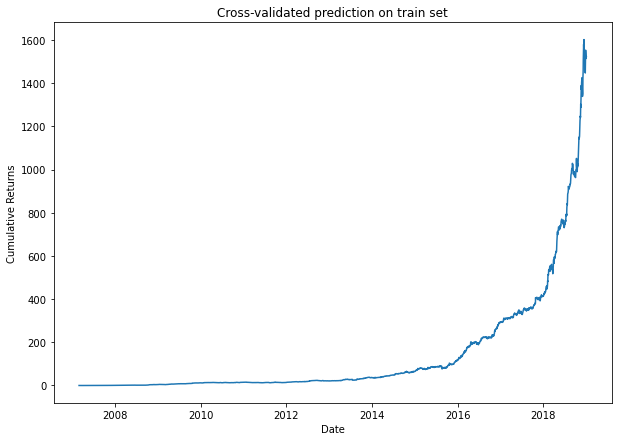

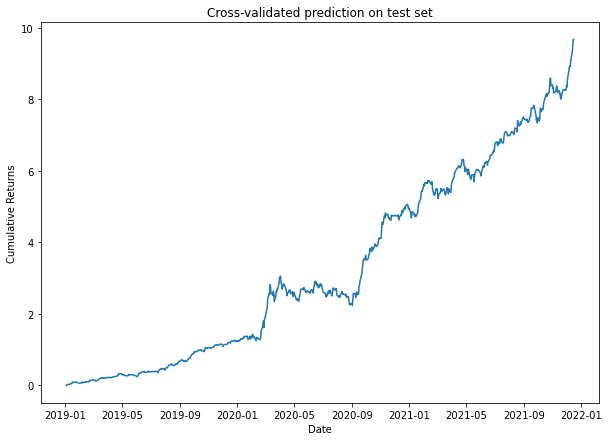

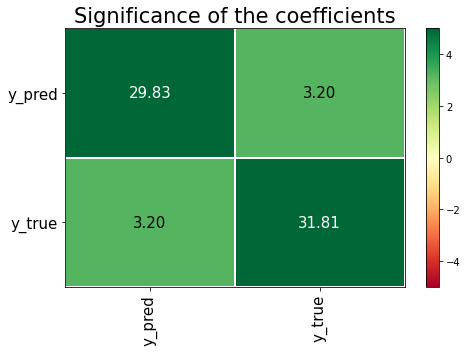

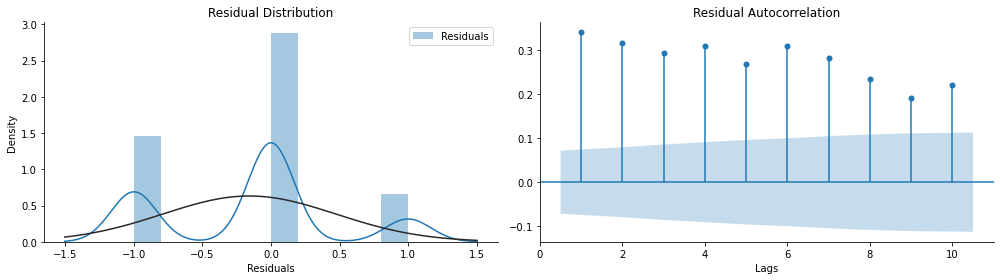

average return 0.014763
[-0.00764183  0.00847419]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.0


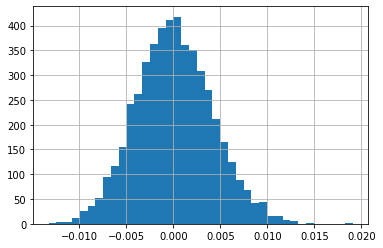

In [ ]:
plot(stack_classifier, yc_test)

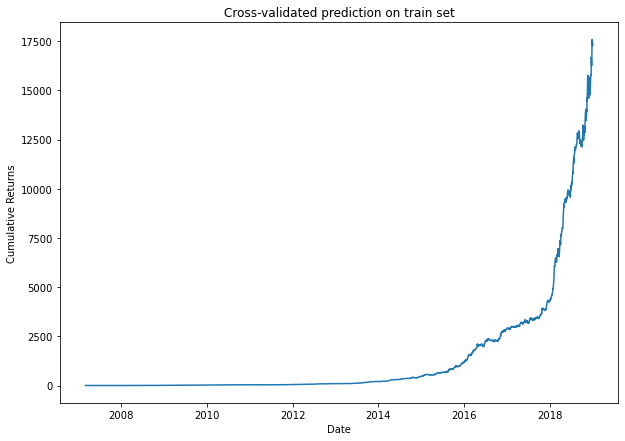

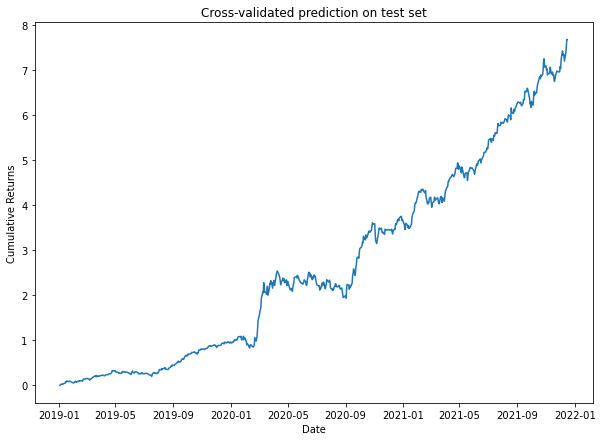

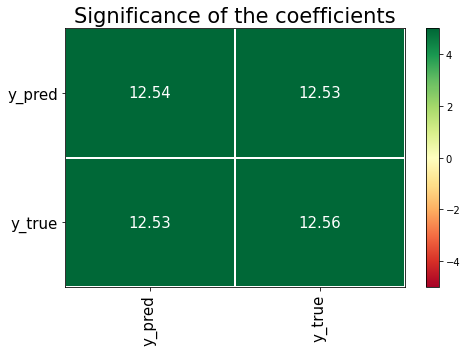

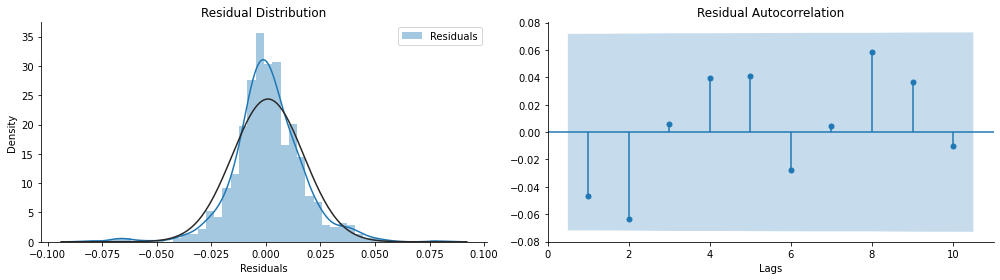

average return 0.014570
[-0.00758637  0.00808576]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.00019999999999997797


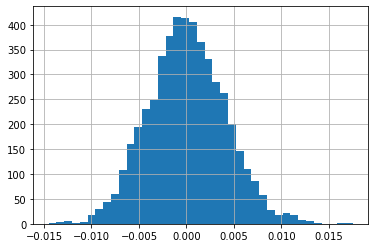

In [ ]:
plot(stack_reg, y_test)

### Recommended final model based on evaluation metrics:
The stacking ensemble of regression models are recommended as the optimal model to perform stock price prediction, based on its enhanced performance at predicting the highest CAGR and Sharpe ratio with minimal overfitting and more generalization.

### Interpatation on the residuals:

Interpretation on the plots: 
Observing from the significance matrix, a high value of the correlation coefficient indicates that the correlation between test y_pred and y_true is statistically significant. The residual histogram and ACF plot showed that the residuals are normally distributed and the autocorrelation between residuals are not large enough to have noticeable impact on the forecasts or the prediction intervals.



### Interpratation on the p-value:
The p-value is calculated based on the count that are greater than the average return. It gives a direct estimate of the data-mining bias. The small p-value of 0.0002 is small enough to reject the null hypothesis that the prediction of the best model has no predictive superiority over a given benchmark mode, permitting account to be taken of the effects of data snooping. A small p-value also indicates that there is a strong correlation between the residuals, meaning the predicted values and true values are closely related. 